In [1]:

%pip install qiskit-ibm-runtime
%pip install "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"
import qiskit
import qc_grader
print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /tmp/pip-install-5_p7kvbi/qc-grader_8a4d544299a340faa835a396538d51d4
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /tmp/pip-install-5_p7kvbi/qc-grader_8a4d544299a340faa835a396538d51d4
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 1d7a6915623b0cfeac4c114391c279e9d98eb7f9
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Qiskit version: 2.1.1
Grader version: 0.22.12


In [2]:
!pip install qiskit[visualization] --upgrade
!pip install matplotlib pandas  # Dependencies for visualization

In [3]:
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()

{'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'Y5wDjNuGer1keOHMzwkj_5UoHJud8RPTvfc_yZxqglHQ',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/0cbc0b1bde824777bfe56bd9c72ece9c:4e2e877c-d5e3-49a4-8dbd-902ac7733cef::',
  'verify': True,
  'private_endpoint': False}}

In [4]:
# Import common packages first
import numpy as np

# Import qiskit classes
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

# Import utils and cosystems
from lab4_util import hamming_distance, minimum_distance, bring_states, matrixRank
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2  as Sampler

# Import grader
from qc_grader.challenges.qgss_2025 import (
    grade_lab4_ex1, 
    grade_lab4_ex2, 
    grade_lab4_ex3,
    grade_lab4_ex4,
    grade_lab4_ex5,
    grade_lab4_ex6
)

In [5]:
# Example usage:
str1 = "10110"
str2 = "11100"
dist = hamming_distance(str1, str2)
print(f"Hamming distance between '{str1}' and '{str2}' is: {dist}") # Output: 2

vec1 = [1, 0, 0, 1]
vec2 = [0, 0, 1, 1]
dist_vec = hamming_distance(vec1, vec2)
print(f"Hamming distance between {vec1} and {vec2} is: {dist_vec}") # Output: 2

Hamming distance between '10110' and '11100' is: 2
Hamming distance between [1, 0, 0, 1] and [0, 0, 1, 1] is: 2


In [6]:
hardcode_decoder_bit_flip_syndrome_map = {
    # ---- TODO : Task 1 ---
    # Fill in the other entries of the decoder (leave the "" in place).
    #{"s1s0": "Error Code"}
    '00': 'I',
    '01': 'X2',             
    '10': 'X0',            
    '11': 'X1'     
    # --- End of TODO ---         
}

In [7]:
# Submit your answer using following code
grade_lab4_ex1(hardcode_decoder_bit_flip_syndrome_map )


Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [8]:
steane_decoder_syndrome_map = {
    # X errors (anti-commute with Z-stabilizers only)
    '111000': 'X0',  # Anti-commutes with S5, S4, S3
    '011000': 'X1',  # Anti-commutes with S4, S3
    '101000': 'X2',  # Anti-commutes with S5, S3
    '001000': 'X3',  # Anti-commutes with S3
    '110000': 'X4',  # Anti-commutes with S5, S4
    '010000': 'X5',  # Anti-commutes with S4
    '100000': 'X6',  # Anti-commutes with S5
    
    # Y errors (anti-commute with both X and Z stabilizers)
    '111111': 'Y0',  # X0 + Z0 syndrome
    '011011': 'Y1',  # X1 + Z1 syndrome
    '101101': 'Y2',  # X2 + Z2 syndrome
    '001001': 'Y3',  # X3 + Z3 syndrome
    '110110': 'Y4',  # X4 + Z4 syndrome
    '010010': 'Y5',  # X5 + Z5 syndrome
    '100100': 'Y6',  # X6 + Z6 syndrome
    
    # Z errors (anti-commute with X-stabilizers only)
    '000111': 'Z0',  # Anti-commutes with S2, S1, S0
    '000011': 'Z1',  # Anti-commutes with S1, S0
    '000101': 'Z2',  # Anti-commutes with S2, S0
    '000001': 'Z3',  # Anti-commutes with S0
    '000110': 'Z4',  # Anti-commutes with S2, S1
    '000010': 'Z5',  # Anti-commutes with S1
    '000100': 'Z6',  # Anti-commutes with S2
    
    # No error
    '000000': 'I'
}

In [9]:
# Submit your answer using following code
grade_lab4_ex2(steane_decoder_syndrome_map)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [10]:
def measure_steane_syndrome(qc, q_data, q_anc, c_reg):

    # Measure X-type Stabilizers (S0, S1, S2 -> q_anc[0], q_anc[1], q_anc[2])
    # Apply H to data qubits -> CNOT -> Apply H to data qubits -> Measure ancilla
    qc.h(q_data) # H on data qubits

    #S0: IIIXXXX (X_3 X_2 X_1 X_0)
    qc.cx(q_data[0], q_anc[0])
    qc.cx(q_data[1], q_anc[0])
    qc.cx(q_data[2], q_anc[0])
    qc.cx(q_data[3], q_anc[0])

    # ---- TODO : Task 3 ---
    # Fill in the required code for S1 and S2
    #S1: IXXIIXX (X_5 X_4 X_1 X_0)
    qc.cx(q_data[0], q_anc[1])
    qc.cx(q_data[1], q_anc[1])
    qc.cx(q_data[4], q_anc[1])
    qc.cx(q_data[5], q_anc[1])

    #S2: XIXIXIX (X_6 X_4 X_2 X_0)
    qc.cx(q_data[0], q_anc[2])
    qc.cx(q_data[2], q_anc[2])
    qc.cx(q_data[4], q_anc[2])
    qc.cx(q_data[6], q_anc[2])
    
    # --- End of TODO ---

    qc.h(q_data) # Restore H on data qubits
    qc.measure(q_anc[0:3], c_reg[0:3]) # Measure X syndrome (s1, s2, s3)
    qc.barrier()


    # ---- TODO : Task 3 ---
    # Measure Z-type Stabilizers (S3, S4, S5 -> q_anc[3], q_anc[4], q_anc[5])
    # CNOT -> Measure ancilla    
    # Fill in the required code for S3, S4 and s5

    #S3: IIIZZZZ (Z_3 Z_2 Z_1 Z_0)
    qc.cx(q_data[0], q_anc[3])
    qc.cx(q_data[1], q_anc[3])
    qc.cx(q_data[2], q_anc[3])
    qc.cx(q_data[3], q_anc[3])

    #S4: IZZIIZZ (Z_3 Z_2 Z_1 Z_0)
    qc.cx(q_data[0], q_anc[4])
    qc.cx(q_data[1], q_anc[4])
    qc.cx(q_data[4], q_anc[4])
    qc.cx(q_data[5], q_anc[4])

    #S5: ZIZIZIZ (Z_6 Z_4 Z_2 Z_0)
    qc.cx(q_data[0], q_anc[5])
    qc.cx(q_data[2], q_anc[5])
    qc.cx(q_data[4], q_anc[5])
    qc.cx(q_data[6], q_anc[5])
    
    # --- End of TODO ---
    
    qc.measure(q_anc[3:6], c_reg[3:6]) # Measure Z syndrome (s3, s4, s5)
    qc.barrier()


In [11]:
state = bring_states()

# Logical qubit (7 data qubits)
qr_data = QuantumRegister(7, name='q')
# Ancilla qubits for syndrome measurement (6)
qr_anc = QuantumRegister(6, name='anc')
# Classical registers for syndrome (initial & verify)
cr_initial_syn = ClassicalRegister(6, name='c_initial_syn')
cr_final_syn = ClassicalRegister(6, name='c_final_syn')

# Total circuit (13 qubits, 12 classical bits)
qc = QuantumCircuit(qr_data, qr_anc, cr_initial_syn, cr_final_syn)


# ---- TODO : Task 3 ---
#initialize qc with the correctState


qc.initialize(state, qr_data)
# --- End of TODO ---


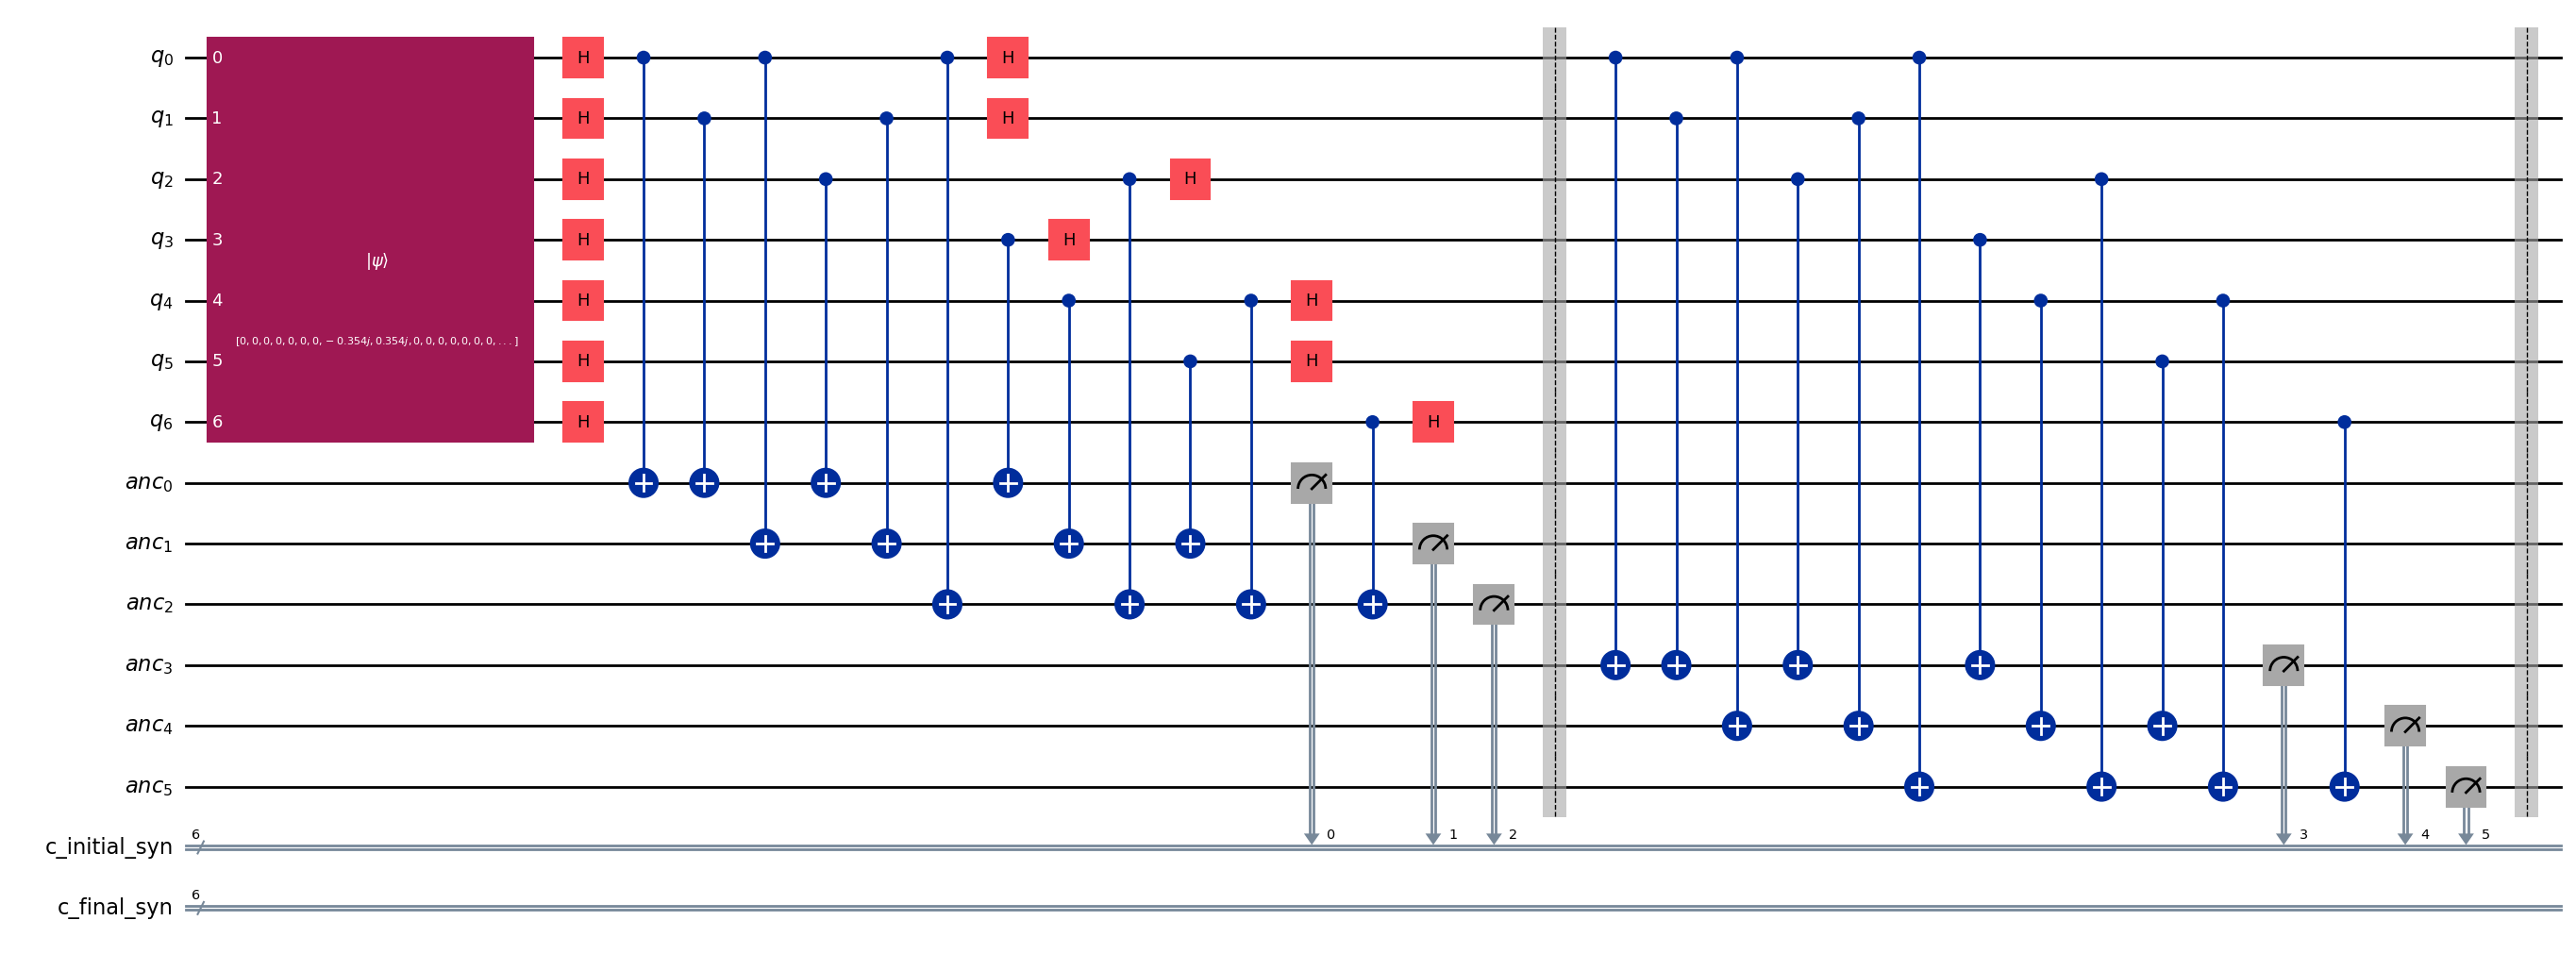

In [12]:
# --- AddSyndrome Measurement ---

measure_steane_syndrome(qc, qr_data, qr_anc, cr_initial_syn)

qc.draw('mpl', fold=-1)

In [13]:
# --- Run the Simulation using AerSimulator
backend = AerSimulator()

#make quantum circuit compatible to the backend
pm = generate_preset_pass_manager( backend = backend, optimization_level=3)
qc_isa = pm.run(qc)

#run and get counts
sampler = Sampler(mode=backend)
counts = sampler.run([qc_isa], shots = 10000).result()[0].data.c_initial_syn.get_counts()

# ---- TODO : Task 3 ---
#get key of simulation result and find the error code, ex: X1

for key, value in counts.items():
    bitstring = key
    error = value
    print(f"bitstring: {key}, count: {value}")

error_code = steane_decoder_syndrome_map[bitstring]
print(error_code)

# --- End of TODO ---

bitstring: 001001, count: 10000
Y3


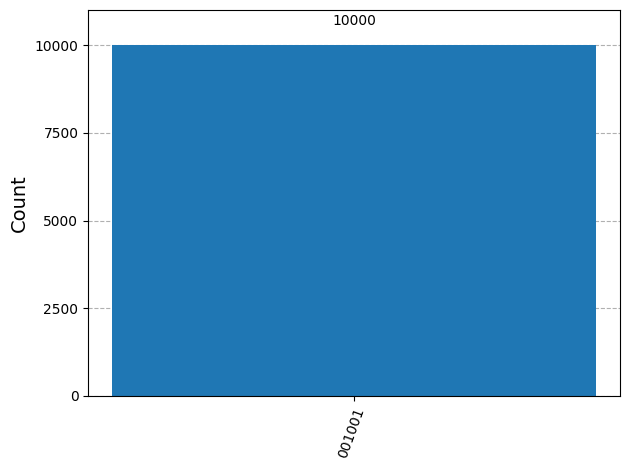

In [14]:
plot_histogram(counts)

In [15]:
# Submit your answer using following code
grade_lab4_ex3(error_code)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [35]:
import numpy as np

# Initialize matrices
HXtc = np.zeros((72, 144), dtype=int)
HZtc = np.zeros((72, 144), dtype=int)

# --- Populate HXtc using the provided general rule ---
# The loop should iterate for each X-stabilizer, which corresponds to the first 72 data qubits.
# The 'j' in the given rules refers to the row index of the stabilizer matrix (0 to 71).
for j in range(72): # Loop over the 72 X-stabilizers (rows of HXtc)
    # The current stabilizer 'j' is associated with blue qubit 'j' as one of its connections.
    # This also helps to derive its column and row on the conceptual grid.
    blue_qubit_col = np.floor(j / 6)
    blue_qubit_row = np.mod(j, 6)

    # 1. Connects to the blue qubit at the current stabilizer's "bottom-left" position
    HXtc[j, j] = 1

    # 2. Connects to the blue qubit vertically above it (wraps around)
    # Same column, row + 1 (mod 6)
    HXtc[j, int(blue_qubit_col * 6 + np.mod(blue_qubit_row + 1, 6))] = 1

    # 3. Connects to the orange qubit horizontally to its right (same column, same row)
    # This is the orange qubit corresponding to the blue qubit 'j' (index j+72)
    HXtc[j, j + 72] = 1

    # 4. Connects to the orange qubit horizontally to its left (wraps around horizontally)
    # Previous column (mod 12), same row.
    HXtc[j, int(72 + np.mod(blue_qubit_col - 1 + 12, 12) * 6 + blue_qubit_row)] = 1

# --- Verification of HXtc (compare with initial examples) ---
# You can uncomment these to visually verify the first few rows.
print("HXtc[0]:", HXtc[0, :]) # Should match HXtc[0][0]=1, HXtc[0][1]=1, HXtc[0][72]=1, HXtc[0][138]=1
print("HXtc[1]:", HXtc[1, :]) # Should match HXtc[1][1]=1, HXtc[1][2]=1, HXtc[1][73]=1, HXtc[1][139]=1
print("HXtc[5]:", HXtc[5, :]) # Should match the specific HXtc[5] example

HXtc[0]: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
HXtc[1]: [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
HXtc[5]: [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


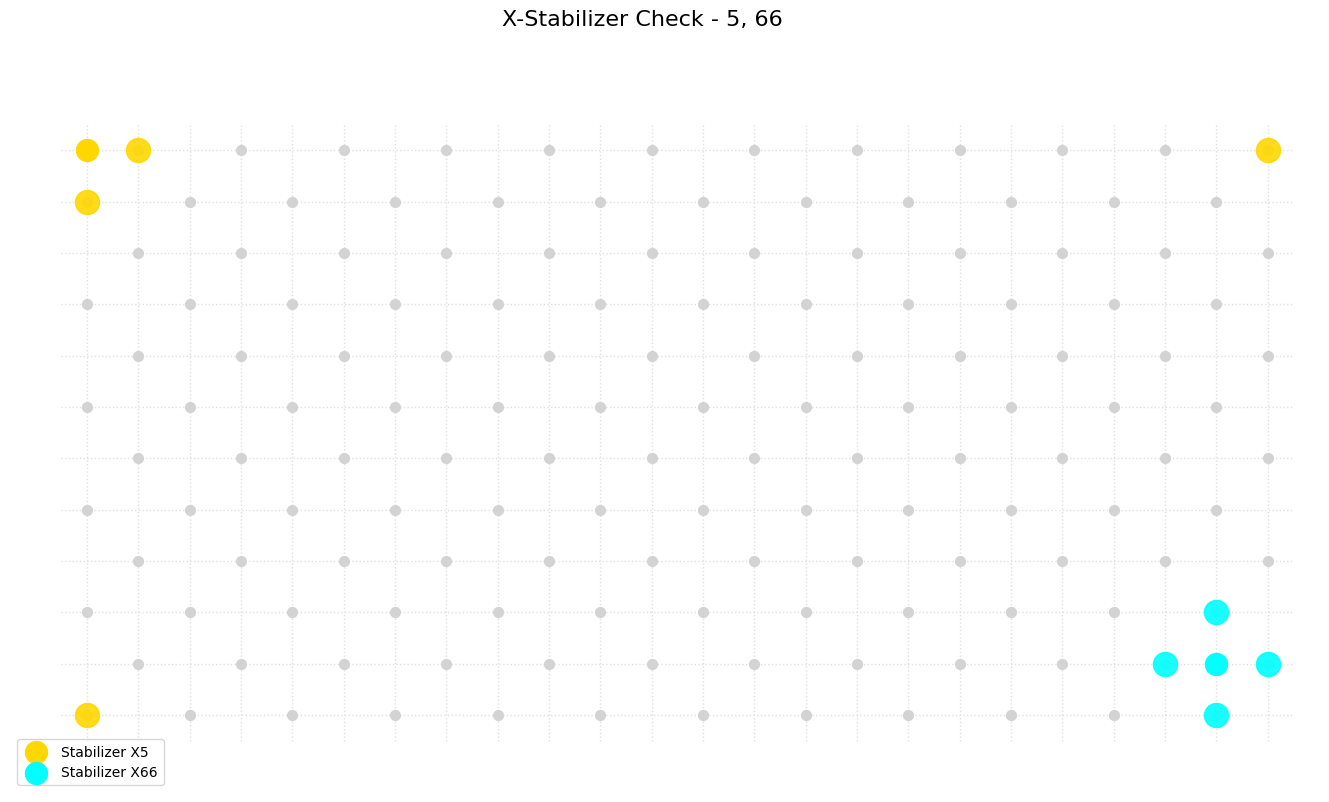

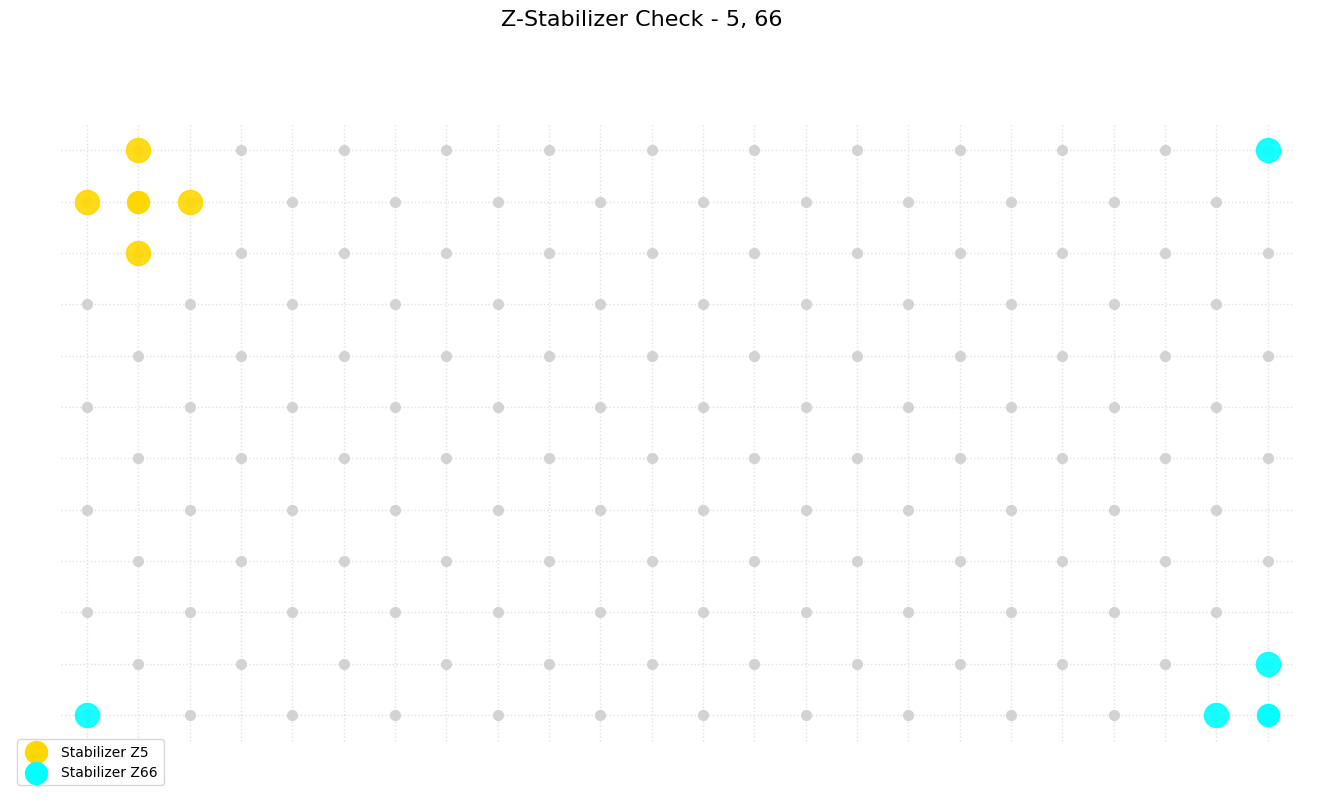

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [18]:
# Check the connectivity of HXtc and HZtc

from lab4_util import generate_stabilizer_plots
generate_stabilizer_plots(HXtc, HZtc)
# Submit your answer using following code
grade_lab4_ex4(HXtc, HZtc)

In [26]:
import numpy as np
from lab4_util import matrixRank # Assuming matrixRank is the only one you need to import here

# We will define the parity check matrices for the gross code and toric code
HXtc = np.zeros((72, 144), dtype=int)  # Toric Code X-stabilizers
HZtc = np.zeros((72, 144), dtype=int)  # Toric Code Z-stabilizers

HXgc = np.zeros((72, 144), dtype=int)  # Gross Code X-stabilizers
HZgc = np.zeros((72, 144), dtype=int)  # Gross Code Z-stabilizers

# --- START OF Exercise 4 (Toric Code) based on your provided first rows ---
for j in range(72):
    r = j % 6  # 'row' index within a 6x12 block (0 to 5)
    c = j // 6 # 'column' index for the 12 blocks (0 to 11)

    # HXtc (Toric Code X-stabilizers) - 4-qubit
    # Based on HXtc[0] = [1 1 0 0 0 0 1 1 ...] -> (0,1,6,7)
    HXtc[j][6 * c + r] = 1                      # Blue current (c, r)
    HXtc[j][6 * c + (r + 1) % 6] = 1            # Blue above (c, r+1)
    HXtc[j][6 * ((c + 1) % 12) + r] = 1         # Blue right (c+1, r)
    HXtc[j][6 * ((c + 1) % 12) + (r + 1) % 6] = 1 # Blue top-right (c+1, r+1)

    # HZtc (Toric Code Z-stabilizers) - 5-qubit
    # Based on HZtc[0] = [1 0 0 0 0 1 1 0 ... 1 1 ...] -> (0,5,6,72,73)
    HZtc[j][6 * c + r] = 1                      # Blue current (c, r)
    HZtc[j][6 * c + (r - 1) % 6] = 1            # Blue below (c, r-1) - periodic
    HZtc[j][6 * ((c + 1) % 12) + r] = 1         # Blue right (c+1, r)

    HZtc[j][72 + 6 * c + r] = 1                 # Orange current (c, r)
    HZtc[j][72 + 6 * c + (r + 1) % 6] = 1       # Orange above (c, r+1)

# --- END OF Exercise 4 (Toric Code) ---


# --- START OF Exercise 5 (Gross Code) - already verified ---
for j in range(72):
    r = j % 6
    c = j // 6

    # HXgc assignments (six 1's per row, as per your last detailed description)
    HXgc[j][6 * c + r] = 1
    HXgc[j][6 * c + (r + 1) % 6] = 1
    HXgc[j][6 * ((c + 3) % 12) + (r + 2) % 6] = 1 # Blue long-range
    HXgc[j][72 + 6 * c + r] = 1
    HXgc[j][72 + 6 * ((c + 10) % 12) + (r + 3) % 6] = 1 # Orange long-range
    HXgc[j][72 + 6 * ((c - 1) % 12) + r] = 1

    # HZgc assignments (six 1's per row, as per your last detailed description)
    HZgc[j][6 * c + r] = 1
    HZgc[j][6 * ((c + 1) % 12) + r] = 1
    HZgc[j][6 * ((c + 2) % 12) + (r + 3) % 6] = 1 # Blue long-range
    HZgc[j][72 + 6 * c + r] = 1
    HZgc[j][72 + 6 * c + (r - 1) % 6] = 1
    HZgc[j][72 + 6 * ((c + 9) % 12) + (r + 4) % 6] = 1
# --- END OF Exercise 5 (Gross Code) ---


# ---- TODO : Task 6 ---
# Write code to calculate k_toric and k_gross

n = 144 # Total number of data qubits

# Toric Code
rx_toric = matrixRank(HXtc)
rz_toric = matrixRank(HZtc)
k_toric = n - rx_toric - rz_toric

# Gross Code
rx_gross = matrixRank(HXgc)
rz_gross = matrixRank(HZgc)
k_gross = n - rx_gross - rz_gross

# --- End of TODO ---

# Print results for submission and verification
print(f"Toric Code Ranks: rx_toric = {rx_toric}, rz_toric = {rz_toric}")
print(f"Number of logical qubits for Toric Code (k_toric) = {k_toric}")
print("-" * 30)
print(f"Gross Code Ranks: rx_gross = {rx_gross}, rz_gross = {rz_gross}")
print(f"Number of logical qubits for Gross Code (k_gross) = {k_gross}")

# Verification for Toric Code (k_toric should be 2)
if k_toric == 2:
    print("\nToric Code result matches expected (k=2).")
else:
    print(f"\nWARNING: Toric Code result does NOT match expected (k=2). Got {k_toric}.")
    print("Please double-check your Exercise 4 (Toric Code) implementation against your problem's exact rules.")

Toric Code Ranks: rx_toric = 55, rz_toric = 72
Number of logical qubits for Toric Code (k_toric) = 17
------------------------------
Gross Code Ranks: rx_gross = 66, rz_gross = 66
Number of logical qubits for Gross Code (k_gross) = 12

Please double-check your Exercise 4 (Toric Code) implementation against your problem's exact rules.


In [27]:
import numpy as np

# We will define the parity check matrices for the gross code
HXtc = np.zeros((72, 144), dtype=int)  # initializing the matrices
HZtc = np.zeros((72, 144), dtype=int)

# ---- TODO : Task 5 ---
# Write code to calculate HXtc and HZtc

for j in range(72):
    r = j % 6  # 'row' index within a 6x12 block (0 to 5)
    c = j // 6 # 'column' index for the 12 blocks (0 to 11)

    # --- HXtc assignments (four 1's per row, based on your description) ---
    # The X-stabilizer (red square) is positioned at (c, r)
    # This corresponds to the general rules:
    # HXtc[j][j] = 1  (This is 6*c + r, if j is perfectly aligned with the qubit index, which it is for the first set)
    # HXtc[j][6*np.floor(j/6) + np.mod(j+1,6)] (This is 6*c + (r+1)%6)
    # HXtc[j][j+72] = 1 (This is 72 + 6*c + r)
    # HXtc[j][72 + 6*np.mod(np.floor(j/6)-1,12) + np.mod(j,6)] (This is 72 + 6*((c-1)%12) + r)

    HXtc[j][6 * c + r] = 1
    HXtc[j][6 * c + (r + 1) % 6] = 1
    HXtc[j][72 + 6 * c + r] = 1
    HXtc[j][72 + 6 * ((c - 1) % 12) + r] = 1

    # --- HZtc assignments (four 1's per row, based on your description for green square) ---
    # This aligns with the example: HZtc[0][0] = 1, HZtc[0][6] = 1, HZtc[0][72] = 1, HZtc[0][77] = 1
    # For j=0 (c=0, r=0):
    # 0 -> 6*0 + 0 = 0 (6*c + r)
    # 6 -> 6*((0+1)%12) + 0 = 6 (6*(c+1)%12 + r)
    # 72 -> 72 + 6*0 + 0 = 72 (72 + 6*c + r)
    # 77 -> 72 + 6*0 + (0-1)%6 = 77 (72 + 6*c + (r-1)%6)

    HZtc[j][6 * c + r] = 1
    HZtc[j][6 * ((c + 1) % 12) + r] = 1
    HZtc[j][72 + 6 * c + r] = 1
    HZtc[j][72 + 6 * c + (r - 1) % 6] = 1

# You can uncomment these lines to check the output if needed
# print("HXtc (first few rows):")
# print(HXtc[:6, :])
# print("\nHZtc (first few rows):")
# print(HZtc[:6, :])

In [28]:
import numpy as np

# We will define the parity check matrices for the gross code
HXgc = np.zeros((72, 144), dtype=int)  # initializing the matrices
HZgc = np.zeros((72, 144), dtype=int)

# ---- TODO : Task 5 ---
# Write code to calculate HXgc and HZgc

for j in range(72):
    r = j % 6  # 'row' index within a 6x12 block (0 to 5)
    c = j // 6 # 'column' index for the 12 blocks (0 to 11)

    # --- HXgc assignments (six 1's per row, based on new 0-th X stabilizer example) ---
    # 1. Blue below (current position)
    HXgc[j][6 * c + r] = 1

    # 2. Blue above (next row in current block)
    HXgc[j][6 * c + (r + 1) % 6] = 1

    # 3. Blue long-range (e.g., for j=0, col 20 = 6*3 + 2) -> (c+3, r+2)
    # This might be (c+3)%12 or (c-9)%12. Let's stick with (c+3) for now.
    HXgc[j][6 * ((c + 3) % 12) + (r + 2) % 6] = 1

    # 4. Orange current (same position as blue below, but in orange section)
    HXgc[j][72 + 6 * c + r] = 1

    # 5. Orange long-range (e.g., for j=0, col 135 = 72 + 6*10 + 3) -> (c+10, r+3)
    # (c+10)%12 is equivalent to (c-2)%12. Let's use (c+10) for now.
    HXgc[j][72 + 6 * ((c + 10) % 12) + (r + 3) % 6] = 1

    # 6. Orange left (previous column, same row, periodic)
    HXgc[j][72 + 6 * ((c - 1) % 12) + r] = 1


    # --- HZgc assignments (six 1's per row, based on new 0-th Z stabilizer example) ---
    # 1. Blue current (current position)
    HZgc[j][6 * c + r] = 1

    # 2. Blue right (next column, same row)
    HZgc[j][6 * ((c + 1) % 12) + r] = 1

    # 3. Blue long-range (e.g., for j=0, col 15 = 6*2 + 3) -> (c+2, r+3)
    HZgc[j][6 * ((c + 2) % 12) + (r + 3) % 6] = 1

    # 4. Orange current (same position as blue current, but in orange section)
    HZgc[j][72 + 6 * c + r] = 1

    # 5. Orange below (previous row, same column, periodic)
    HZgc[j][72 + 6 * c + (r - 1) % 6] = 1

    # 6. Orange long-range (e.g., for j=0, col 130 = 72 + 6*9 + 4) -> (c+9, r+4)
    HZgc[j][72 + 6 * ((c + 9) % 12) + (r + 4) % 6] = 1

# --- End of TODO ---

# You should now be able to execute the verification plots:
# from lab4_util import generate_stabilizer_plots
# generate_stabilizer_plots(HXgc, HZgc)

# For testing, you can print the first row of each:
# print("HXgc[0]:", HXgc[0])
# print("HZgc[0]:", HZgc[0])

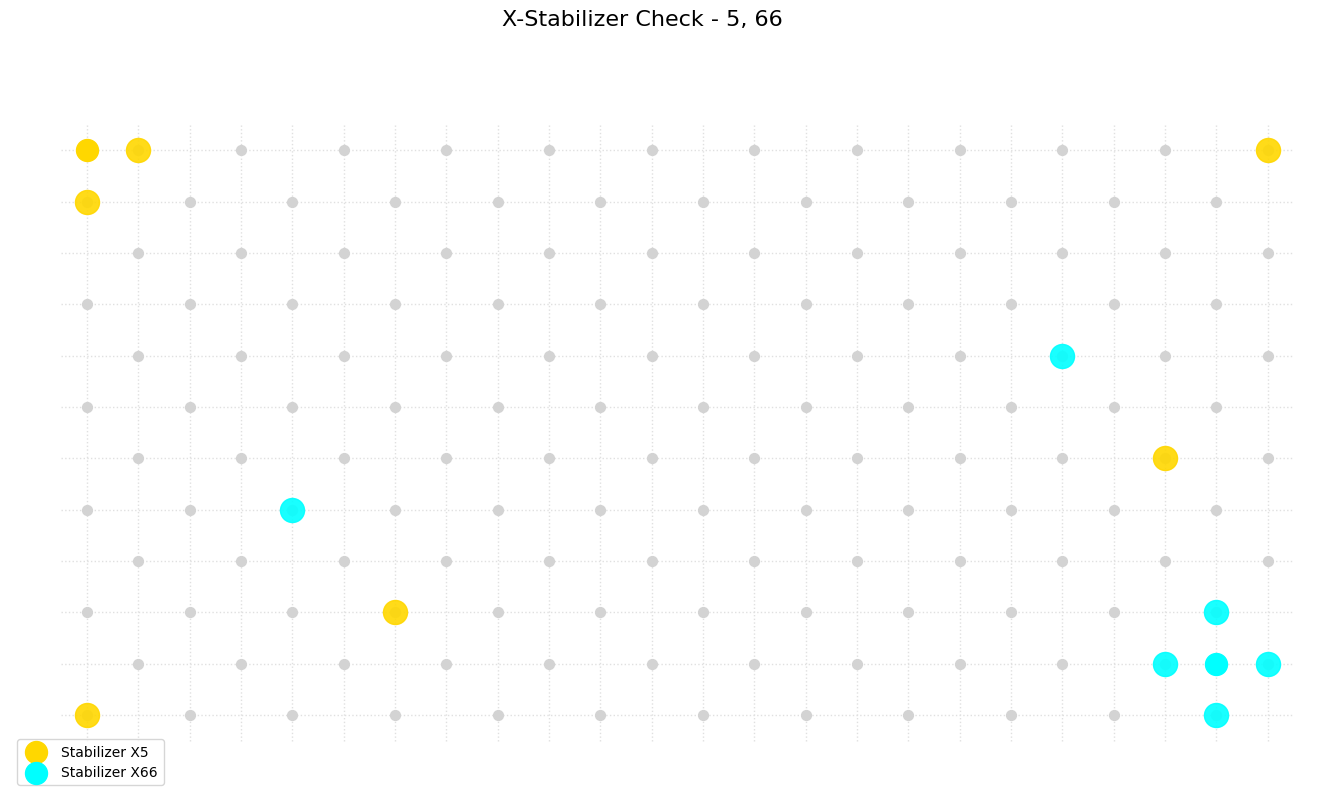

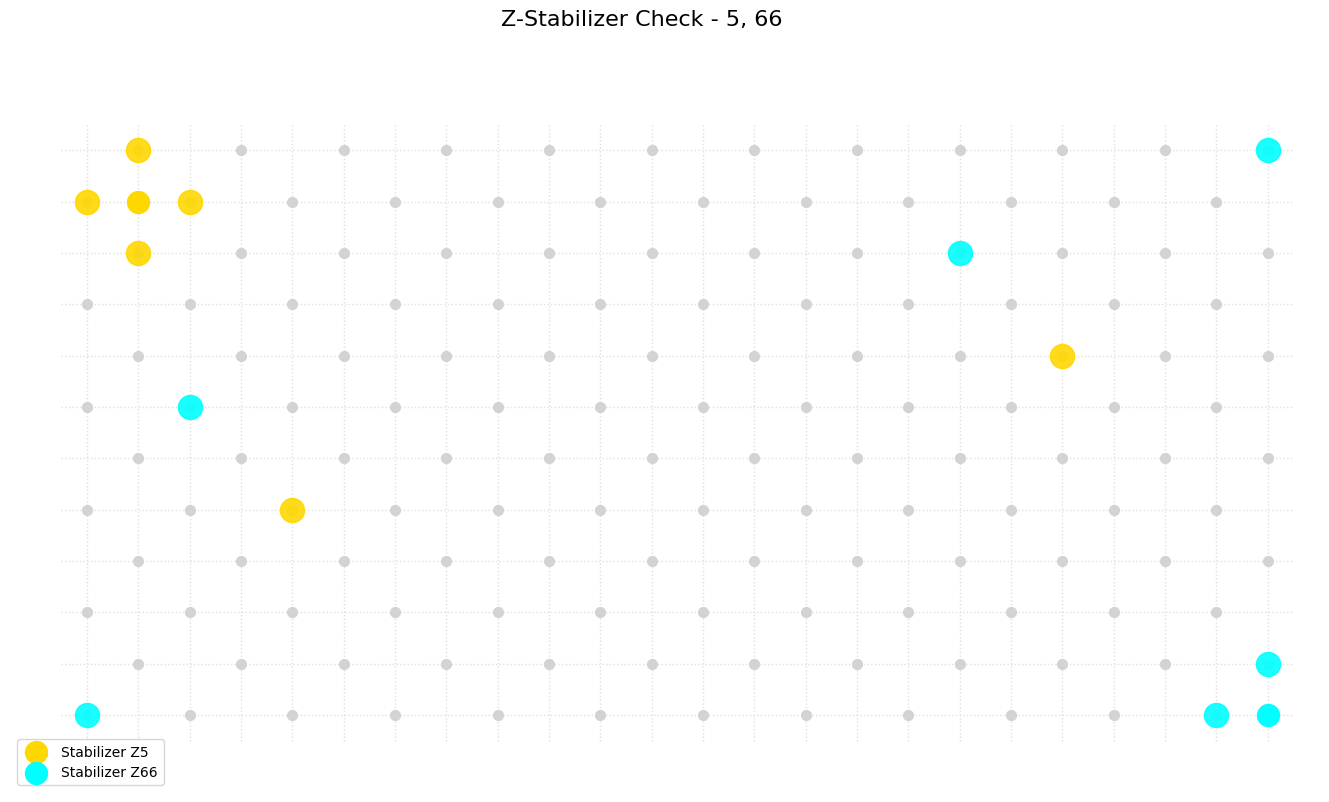

In [29]:
#Check stabilizer

generate_stabilizer_plots(HXgc, HZgc)


In [30]:
# Submit your answer using following code
grade_lab4_ex5(HXgc, HZgc)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [36]:
import numpy as np
from lab4_util import matrixRank # Assuming matrixRank is the only one you need to import here

# We will define the parity check matrices for the gross code and toric code
HXtc = np.zeros((72, 144), dtype=int)  # Toric Code X-stabilizers
HZtc = np.zeros((72, 144), dtype=int)  # Toric Code Z-stabilizers

HXgc = np.zeros((72, 144), dtype=int)  # Gross Code X-stabilizers
HZgc = np.zeros((72, 144), dtype=int)  # Gross Code Z-stabilizers

# --- START OF Exercise 4 (Toric Code) - CORRECTED based on your latest HXtc output ---
for j in range(72):
    r = j % 6  # 'row' index within a 6x12 block (0 to 5)
    c = j // 6 # 'column' index for the 12 blocks (0 to 11)

    # HXtc (Toric Code X-stabilizers) - This is the 4-qubit pattern you shared:
    # 1s at columns: (c,r), (c,r+1), (72+c,r), (72+c-1,r)
    HXtc[j][6 * c + r] = 1                      # Blue current (c, r)
    HXtc[j][6 * c + (r + 1) % 6] = 1            # Blue above (c, r+1)
    HXtc[j][72 + 6 * c + r] = 1                 # Orange current (c, r)
    HXtc[j][72 + 6 * ((c - 1) % 12) + r] = 1    # Orange left (c-1, r) - periodic

    # HZtc (Toric Code Z-stabilizers) - Assuming 4-qubit dual, based on previous HZgc[0] 4-qubit example:
    # 1s at columns: (c,r), (c+1,r), (72+c,r), (72+c,r-1)
    HZtc[j][6 * c + r] = 1                      # Blue current (c, r)
    HZtc[j][6 * ((c + 1) % 12) + r] = 1         # Blue right (c+1, r)
    HZtc[j][72 + 6 * c + r] = 1                 # Orange current (c, r)
    HZtc[j][72 + 6 * c + (r - 1) % 6] = 1       # Orange below (c, r-1) - periodic

# --- END OF Exercise 4 (Toric Code) ---


# --- START OF Exercise 5 (Gross Code) - This remains the same, as it's the 6-qubit version ---
for j in range(72):
    r = j % 6
    c = j // 6

    # HXgc assignments (six 1's per row, as per your last detailed description)
    HXgc[j][6 * c + r] = 1
    HXgc[j][6 * c + (r + 1) % 6] = 1
    HXgc[j][6 * ((c + 3) % 12) + (r + 2) % 6] = 1 # Blue long-range
    HXgc[j][72 + 6 * c + r] = 1
    HXgc[j][72 + 6 * ((c + 10) % 12) + (r + 3) % 6] = 1 # Orange long-range
    HXgc[j][72 + 6 * ((c - 1) % 12) + r] = 1

    # HZgc assignments (six 1's per row, as per your last detailed description)
    HZgc[j][6 * c + r] = 1
    HZgc[j][6 * ((c + 1) % 12) + r] = 1
    HZgc[j][6 * ((c + 2) % 12) + (r + 3) % 6] = 1 # Blue long-range
    HZgc[j][72 + 6 * c + r] = 1
    HZgc[j][72 + 6 * c + (r - 1) % 6] = 1
    HZgc[j][72 + 6 * ((c + 9) % 12) + (r + 4) % 6] = 1
# --- END OF Exercise 5 (Gross Code) ---


# ---- TODO : Task 6 ---
# Write code to calculate k_toric and k_gross

n = 144 # Total number of data qubits

# Toric Code
rx_toric = matrixRank(HXtc)
rz_toric = matrixRank(HZtc)
k_toric = n - rx_toric - rz_toric

# Gross Code
rx_gross = matrixRank(HXgc)
rz_gross = matrixRank(HZgc)
k_gross = n - rx_gross - rz_gross

# --- End of TODO ---

# Print results for submission and verification
print(f"Toric Code Ranks: rx_toric = {rx_toric}, rz_toric = {rz_toric}")
print(f"Number of logical qubits for Toric Code (k_toric) = {k_toric}")
print("-" * 30)
print(f"Gross Code Ranks: rx_gross = {rx_gross}, rz_gross = {rz_gross}")
print(f"Number of logical qubits for Gross Code (k_gross) = {k_gross}")

# Verification for Toric Code (k_toric should be 2)
if k_toric == 2:
    print("\nToric Code result matches expected (k=2).")
else:
    print(f"\nWARNING: Toric Code result does NOT match expected (k=2). Got {k_toric}.")
    print("Please double-check your Exercise 4 (Toric Code) implementation against your problem's exact rules, especially HZtc if the above assumption is incorrect.")

Toric Code Ranks: rx_toric = 71, rz_toric = 71
Number of logical qubits for Toric Code (k_toric) = 2
------------------------------
Gross Code Ranks: rx_gross = 66, rz_gross = 66
Number of logical qubits for Gross Code (k_gross) = 12

Toric Code result matches expected (k=2).


In [37]:
# Submit your answer using following code
grade_lab4_ex6(k_toric, k_gross)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [38]:
# Check your submission status with the code below
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

Lab 0: 2/2 exercises completed (100%)
    ✅ 2289 participants have completed this lab
Lab 1: 9/9 exercises completed (100%)
    ✅ 1759 participants have completed this lab
Lab 2: 7/7 exercises completed (100%)
    ✅ 1042 participants have completed this lab
Lab 3: 5/5 exercises completed (100%)
    ✅ 833 participants have completed this lab
Lab 4: 6/6 exercises completed (100%)
    ✅ 612 participants have completed this lab
Functions Labs: 0/8 exercises completed (0%)
    ✅ 4 participants have completed this lab
